In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

In [2]:
# pulse parameters
FWHM = 0.03         # pulse duration (ps)
pulseWL = 800       # pulse central wavelength (nm)
EPP = 0.75e-3       # Energy per pulse (J)
GDD = 0.0           # Group delay dispersion (ps^2)
TOD = 0.0           # Third order dispersion (ps^3)

# fibre parameters
Length = 1000       # length in mm
Alpha = 0.0         # attentuation coefficient (dB/cm)
fiber_rad = 125e-6  # radius (m)
fibWL = pulseWL     # Center WL of fiber (nm)

alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

# Neon gas at 800nm, dispersive coefficients (betas), pressure-dependent nonlinear refractive index (n2)
beta2 = 0.0202              # (fs^2/cm)
beta3 = 0.0158              # (fs^3/cm)
n2_Ne_at_one_bar = 1.4e-24  # (m^2/W bar), (Arnaud Couairon, et al, 2008)

pressure = 2.31                   # (bar)
n2 = n2_Ne_at_one_bar * pressure  # (m^2/W)

beta2 *= (1e-3)**2/1e-5     # (ps^2/km)
beta3 *= (1e-3)**3/1e-5     # (ps^3/km)
beta4 = 0                   # (ps^4/km) (value not found)

# nonlinear parameter (gamma)
def nonlinearParameterGamma(n2, pulseWL, fiber_rad):
    """
    Calculate the nonlinear parameter Gamma.
    Based on equation from Agrawal's "Nonlinear Fiber Optics": Gamma = (n2*omega0)/(c*A_eff)
    
    c: speed of light [m/s]
    omega0 = (2*pi*c)/pulseWL: angular frequency [rad/s]
    A_eff: effective core area of the fiber [m^2]
    
    Inputs:
    n2: (pressure-dependent) nonlinear refractive index at specified pressure [m^2/W]
    pulseWL: pulse central wavelength [nm]
    fiber_rad: radius of fiber [m]
    
    Output:
    Gamma: nonlinear parameter [1/(W km)]
    """
    Gamma = ((2*np.pi)/(pulseWL*1e-9)) * \
            (n2/(np.pi*fiber_rad**2)) * (1/1e-3)
    
    return Gamma

Gamma = nonlinearParameterGamma(n2, pulseWL, fiber_rad)

# simulation parameters
Window  = 10.0      # simulation window (ps)
Steps   = 100       # simulation steps
Points  = 2**13     # simulation points
Raman   = True      # Enable Raman effect?
Steep   = True      # Enable self steepening?

In [3]:
# create the pulse
pulse = pynlo.light.DerivedPulses.SechPulse(1, FWHM/1.76, pulseWL, time_window_ps=Window,
                  GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=100, power_is_avg=False)
pulse.set_epp(EPP) # set the pulse energy


In [4]:
# create the fiber
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=(beta2, beta3, beta4),
                              gamma_W_m=Gamma * 1e-3, gvd_units='ps^n/km', gain=-alpha)


C:\Users\shupei\anaconda3\envs\python2\lib\site-packages\jsonpickle\unpickler.py:73: UserWarning: Unpickler.on_missing must be a string or a function! It will be ignored!
  "Unpickler.on_missing must be a string or a function! It will be ignored!"


In [5]:
# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)


Pulse energy before Simple Fiber : 750000.0000000002 nJ
pulse energy in  6506684.421014875
copied as   6506684.421014875
Step: 0 Distance remaining: 1.0
Pulse energy after: 723116.620910404 nJ
Step: 1 Distance remaining: 0.99
Pulse energy after: 723023.1430383387 nJ
Step: 2 Distance remaining: 0.98
Pulse energy after: 722932.6771586606 nJ
Step: 3 Distance remaining: 0.97
Pulse energy after: 722845.1666539822 nJ
Step: 4 Distance remaining: 0.96
Pulse energy after: 722760.550431072 nJ
Step: 5 Distance remaining: 0.95
Pulse energy after: 722678.7632569665 nJ
Step: 6 Distance remaining: 0.94
Pulse energy after: 722599.7361072397 nJ
Step: 7 Distance remaining: 0.93
Pulse energy after: 722523.396530185 nJ
Step: 8 Distance remaining: 0.92
Pulse energy after: 722449.6690177068 nJ
Step: 9 Distance remaining: 0.91
Pulse energy after: 722378.47538488 nJ
Step: 10 Distance remaining: 0.9
Pulse energy after: 722309.7351716129 nJ
Step: 11 Distance remaining: 0.89
Pulse energy after: 722243.36597833 n

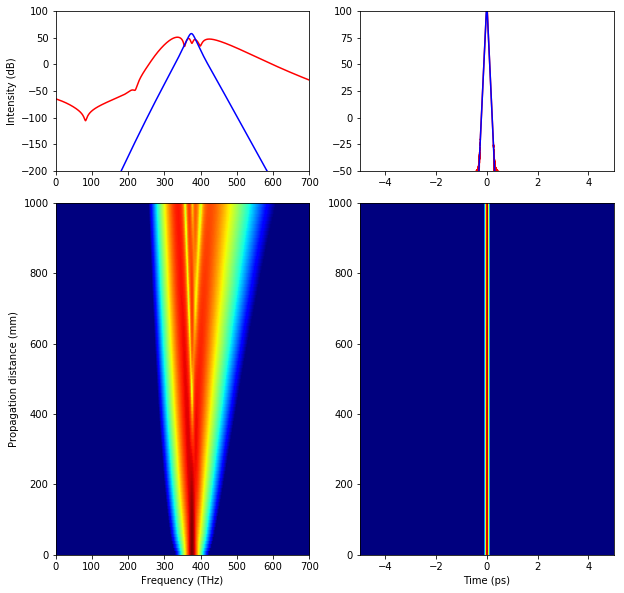

In [6]:
F = pulse.W_mks / (2 * np.pi) * 1e-12 # convert to THz

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB( np.transpose(AW)[:, (F > 0)] )
zT = dB( np.transpose(AT) )

y = y * 1e3 # convert distance to mm


# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)


ax0.plot(F[F > 0],  zW[-1], color='r')
ax1.plot(pulse.T_ps,zT[-1], color='r')

ax0.plot(F[F > 0],   zW[0], color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 60.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax0.set_ylabel('Intensity (dB)')

ax2.set_xlabel('Frequency (THz)')
ax3.set_xlabel('Time (ps)')

ax2.set_ylabel('Propagation distance (mm)')

ax2.set_xlim(0,700)

ax0.set_ylim(-200,100)
ax1.set_ylim(-50,100)

plt.show()